In [1]:
using Turing, Random, AdvancedVI, DelimitedFiles, DataFrames
using Plots
Random.seed!(0);

In [2]:
#Generate data
T = 400

vz, vy = 0.01, 0.1

z_data_0 = 0
z_data = [sin(pi/60) + sqrt(vz)*randn()]
x_data_0 = 0
x_data = [x_data_0 + sqrt(exp(z_data[1]))*randn()]
y_data = [x_data[1]+sqrt(vy)*randn()]
for t=2:T
    append!(z_data, sin(t*pi/60) + sqrt(vz)*randn())
    append!(x_data, x_data[end] + sqrt(exp(z_data[end]))*randn())
    append!(y_data, x_data[end]+sqrt(vy)*randn())
end

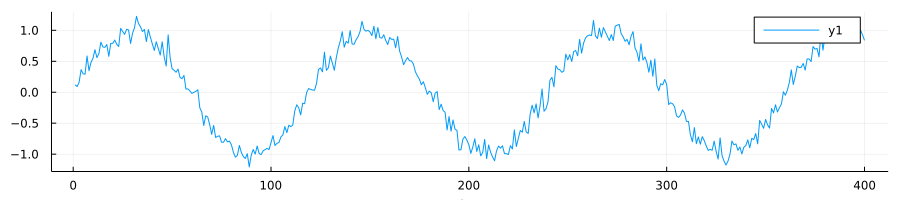

In [3]:
plot(z_data, xlabel="Time", size=(900,200))

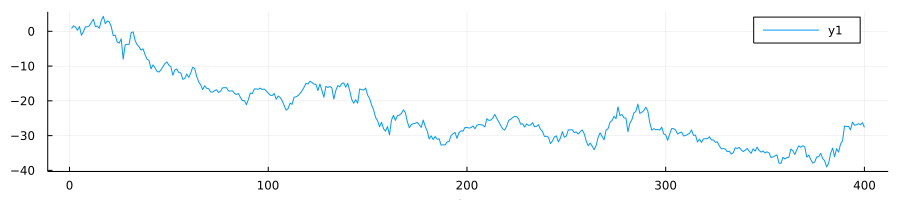

In [4]:
plot(y_data, xlabel="Time", size=(900,200))

In [5]:
@model function HGF(m_z_t_min, v_z_t_min, m_x_t_min, v_x_t_min, y_t)
    model_vz, model_vy = 0.1, 0.1
    z_t_min ~ Normal(m_z_t_min, sqrt(v_z_t_min))
    z_t ~ Normal(z_t_min, sqrt(model_vz))
    x_t_min ~ Normal(m_x_t_min, sqrt(v_x_t_min))
    x_t ~ Normal(x_t_min, sqrt(exp(z_t)))
    y_t ~ Normal(x_t, sqrt(model_vy))
end

HGF (generic function with 2 methods)

In [6]:
# Define values for prior statistics
m_z_0, v_z_0 = 0.0, 1.0
m_x_0, v_x_0 = 0.0, 1.0

m_z_t_min, v_z_t_min = m_z_0, v_z_0
m_x_t_min, v_x_t_min = m_x_0, v_x_0

m_z = Vector{Float64}(undef, T)
v_z = Vector{Float64}(undef, T)
m_x = Vector{Float64}(undef, T)
v_x = Vector{Float64}(undef, T)

for t=1:T
    model = HGF(m_z_t_min, v_z_t_min, m_x_t_min, v_x_t_min, y_data[t])
    chain = sample(model,SMC(),1000)
    m_z_t_min, v_z_t_min, m_x_t_min, v_x_t_min = mean(chain[:z_t]), var(chain[:z_t]), mean(chain[:x_t]), var(chain[:x_t])
    m_z[t], v_z[t], m_x[t], v_x[t] = m_z_t_min, v_z_t_min, m_x_t_min, v_x_t_min
end

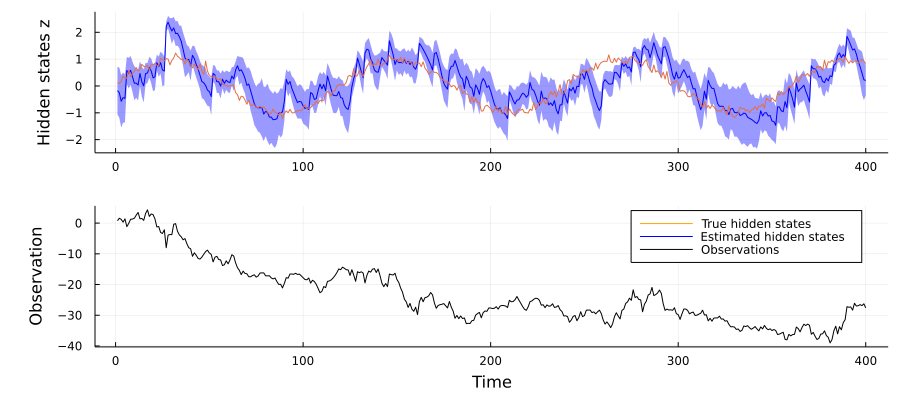

In [7]:
gr()
l = @layout [a ; b]

p1 = plot(m_z, ribbon=v_z, fillalpha=0.4, lw=1, color=:blue, label="Estimated hidden states",legend=false, yaxis="Hidden states z")
plot!(z_data,lw=1,label="True hidden states")

p2 = plot([fill(NaN, T) fill(NaN, T) y_data], lw=1, color=[:orange :blue :black], label=["True hidden states" "Estimated hidden states" "Observations"], legend=:topright, xaxis="Time", yaxis="Observation", link=:x)

p = plot(p1, p2, layout = l, size = (900, 400), left_margin = 10Plots.mm, bottom_margin = 5Plots.mm)

In [8]:
writedlm("SMCmeanestimates.txt", m_z)
writedlm("SMCvarestimates.txt", v_z)